In [11]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers

In [12]:

class PolicyNetwork(tf.keras.Model):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.dense1 = layers.Dense(hidden_size, activation='relu')
        self.dense2 = layers.Dense(action_size, activation='softmax')
        
    def call(self, state):
        x = self.dense1(state)
        probs = self.dense2(x)
        return probs

class ValueFunctionLinear(tf.keras.Model):
    def __init__(self, state_size):
        super(ValueFunctionLinear, self).__init__()
        self.linear = layers.Dense(1, use_bias=False)
        
    def call(self, state):
        value = self.linear(state)
        return tf.squeeze(value, axis=-1)

In [18]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy_net = PolicyNetwork(state_size, action_size)
value_net = ValueFunctionLinear(state_size)

policy_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
value_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

rs = []

gamma = 0.99
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state, _ = state  

    states = []
    actions = []
    rewards = []
    done = False
    
    while not done:
        state_tensor = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
        probs = policy_net(state_tensor)
        action = np.random.choice(action_size, p=np.squeeze(probs))
        
        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        state = next_state
    
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = np.array(returns, dtype=np.float32)
    
    states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
    actions_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
    returns_tensor = tf.convert_to_tensor(returns, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        probs = policy_net(states_tensor)
        action_masks = tf.one_hot(actions_tensor, action_size)
        selected_probs = tf.reduce_sum(probs * action_masks, axis=1)
        log_probs = tf.math.log(selected_probs + 1e-10)
        
        values = value_net(states_tensor)
        advantages = returns_tensor - values
        
        policy_loss = -tf.reduce_mean(log_probs * advantages)
    
    policy_grads = tape.gradient(policy_loss, policy_net.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, policy_net.trainable_variables))
    
    with tf.GradientTape() as tape:
        values = value_net(states_tensor)
        value_loss = tf.keras.losses.MSE(returns_tensor, values)
    
    value_grads = tape.gradient(value_loss, value_net.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, value_net.trainable_variables))
    
    total_reward = sum(rewards)
    rs.append(rewards)
    print(f'Episode {episode}, Total Reward: {total_reward}')
    
env.close()


Episode 0, Total Reward: 77.0
Episode 1, Total Reward: 16.0
Episode 2, Total Reward: 17.0
Episode 3, Total Reward: 27.0
Episode 4, Total Reward: 48.0
Episode 5, Total Reward: 20.0
Episode 6, Total Reward: 36.0
Episode 7, Total Reward: 47.0
Episode 8, Total Reward: 72.0
Episode 9, Total Reward: 28.0
Episode 10, Total Reward: 19.0
Episode 11, Total Reward: 15.0
Episode 12, Total Reward: 61.0
Episode 13, Total Reward: 18.0
Episode 14, Total Reward: 28.0
Episode 15, Total Reward: 17.0
Episode 16, Total Reward: 50.0
Episode 17, Total Reward: 11.0
Episode 18, Total Reward: 22.0
Episode 19, Total Reward: 12.0
Episode 20, Total Reward: 32.0
Episode 21, Total Reward: 26.0
Episode 22, Total Reward: 10.0
Episode 23, Total Reward: 47.0
Episode 24, Total Reward: 42.0
Episode 25, Total Reward: 22.0
Episode 26, Total Reward: 14.0
Episode 27, Total Reward: 41.0
Episode 28, Total Reward: 47.0
Episode 29, Total Reward: 31.0
Episode 30, Total Reward: 22.0
Episode 31, Total Reward: 43.0
Episode 32, Total 

In [19]:
rs2 = [sum(i) for i in rs]

In [23]:
def test_agent(env, policy_net, num_episodes=5):
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state, _ = state
        done = False
        total_reward = 0
        
        while not done:
            env.render()
            state_tensor = tf.expand_dims(tf.convert_to_tensor(state, dtype=tf.float32), 0)
            probs = policy_net(state_tensor)
            action = np.argmax(probs.numpy()[0])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
        
        print(f'Test Episode {episode}, Total Reward: {total_reward}')
    env.close()

In [25]:
env = gym.make('CartPole-v1', render_mode='human')
test_agent(env, policy_net, 10)

Test Episode 0, Total Reward: 115.0
Test Episode 1, Total Reward: 117.0
Test Episode 2, Total Reward: 114.0
Test Episode 3, Total Reward: 127.0
Test Episode 4, Total Reward: 135.0
Test Episode 5, Total Reward: 128.0
Test Episode 6, Total Reward: 110.0
Test Episode 7, Total Reward: 121.0
Test Episode 8, Total Reward: 121.0
Test Episode 9, Total Reward: 114.0


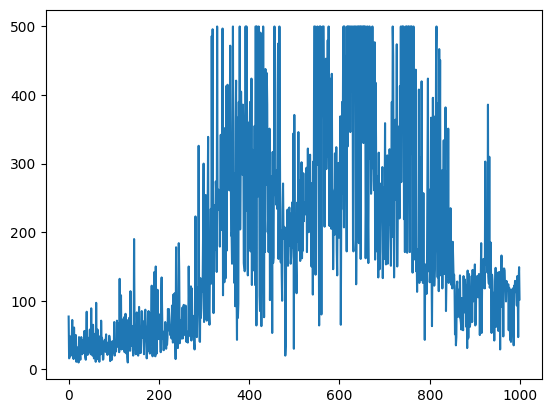

In [26]:
import matplotlib.pyplot as plt

plt.plot(rs2)